# ML Capstone: Iceberg Classifier


## Domain Background

Icebergs presents threats to the ships navigation and various offshore activities. Especially, it as actual problem for the area offshore to Newfoundland and Labrador known as Iceberg Alley. The primary iceberg detection method for now is aerial reconnaissance using vessel-based monitoring data. Also, data received though satellites are widely being integrated now onto the monitoring systems greatly reduce monitoring cost. Additionally, Synthetic Aperture Radar (SAR) satellites can still monitor in various weather conditions such as clouds and fog.
However, manual visual classification of SAR images to identify iceberg is very time-consuming process. So, C‑CORE company (https://www.c-core.ca/) has developed a computer vision system that analyzes SAR data to automatically detect and classify icebergs and vessels. Now it challenges ML community to build effective classification algorithm for their detection system [1]

## Problem Statement

The goal of the project is to build an algorithm which can reliably classify data to identify either it is iceberg or ship, based on given Synthetic Aperture Radar data. Also, the results are clearly measurable using prediction accuracy and it is important to have classifier with higher accuracy (ideally 100%).
Additionally, analysis and classification SAR data is interesting problem. Even if it seems like standard image classification task it has some important differences which makes it challengeable to use pre-trained neural networks with transfer learning for the image classification such as VGG [2] or Inception [3]:
• SAR data is not a three-channels regular image
• Radar detected shapes are different than visually detected shapes.
• Data set has additional incidence angle parameter of which the image was taken. So, it is additional

#### Import nessesary libraries

In [1]:
import json
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

## Datasets and Inputs

CORE provided dataset of satellite SAR images containing either a ship or an iceberg including 1604 training samples and 8424 test samples (5000 from them are autogenerated) Data was collected from SAR which bounces a signal off an object and records the echo, then that data is translated into an image. Two channels of image are provided: HH (transmit/receive horizontally) and HV (transmit horizontally and receive vertically). See [4] for more details. Data was packed to the two JSON files (train.json, test.json). Each file consists of list of satellite images in following format:

Data was packed to the two JSON files (train.json, test.json). Each file consists of list of satellite images in following format: 
* Id of the image 
* band1 – flatten image data of the HH channel (5625 elements, 75x75 image), each element is float value measured in dB. 
* band2 – flatten image data of the HV channel (5625 elements, 75x75 image) , each element is float value measured in dB. 
* inc_angle - the incidence angle of which the image was taken 
* is_iceberg – classification label of the image. 1 is for iceberg, 0 for ship.

Training dataset the only dataset which has labels assigned – so it will be used for training and validation. Test dataset does not have labels and will be used for the model evaluation.
For the model features we are going to use band1, band2 and inc_angle data as features and is_iceberg field as labels.


#### Utility function to load data from JSON file

In [2]:
def read_data(filename):
    with open(filename) as data_file:    
        data = json.load(data_file)
    
    return data

#### Utility functions to find global dataset characteristics (signal strength min/max, angle min/max)

In [3]:
def find_signal_minmax(data):
    mins = [min(min(item['band_1']), min(item['band_2'])) for item in data ]
    maxes = [max(max(item['band_1']), max(item['band_2'])) for item in data ]

    global_min = min(mins)
    global_max = max(maxes)
    
    return global_min, global_max

def find_angle_minmax(data):
    global_min  = min( [item['inc_angle'] for item in data if item['inc_angle'] != 'na'  ])
    global_max = max( [item['inc_angle'] for item in data if item['inc_angle'] != 'na'])
  
    return global_min, global_max

#### Utility functions to extract and display 75*75 image from raw SAR JSON data

In [4]:
def extract_image(data_item, key, image_size = 75):
    image = np.array(data_item[key])
    image = image.reshape(image_size, image_size)
    return image
    
def extract_images(data_item, image_size = 75):
    hh_image = extract_image(data_item, 'band_1', image_size)
    hv_image = extract_image(data_item, 'band_2', image_size)
    return hh_image, hv_image
     
def display_image(image, cmap='gray'):
    plt.imshow(image, cmap=cmap)
    plt.show()

#### Image pre-processing and normalization functions

In [5]:
def global_min_max_scale_sar_image(image, global_min, global_max):
    image = (image - global_min) / (global_max - global_min)
    return image

def local_min_max_scale_sar_image(image):
    img_min = np.min(image)
    img_max = np.max(image)
    
    image = (image - img_min) / (img_max - img_min)
    return image

def local_standard_scale_sar_image(image):
    img_mean = np.mean(image)
    img_std = np.std(image)
    
    image = (image - np.ones_like(image) * img_mean) / img_std;
    
    return image

def flatten_image(image):
    image = image.flatten()
    return image

#### Create 2-channel Images for CNN from HH and HV SAR channels ignoring angle data

In [6]:
def prepare_dataset_ignore_angles(data, process_func):
    X =[]
    labels = []
    ids = []
    
    for item in data:
        hh_image, hv_image = extract_images(item)
        hh_image = process_func(hh_image)
        hv_image = process_func(hv_image)
        
        image = np.dstack((hh_image, hv_image))
        X.append(image)
        if 'is_iceberg' in item.keys():
            labels.append(item['is_iceberg'])
        else:
            labels.append(0)
            
        ids.append(item['id'])
    return np.array(X), np.array(labels), np.array(ids)

#### Create 3-channel Images for CNN from HH and HV SAR channels + angle data as separate layer

In [7]:
def prepare_dataset_with_angles(data, process_func, angle_processing):
    X =[]
    labels = []
    ids = []
    
    for item in data:
        angle = item['inc_angle']
        if angle != 'na':
            hh_image, hv_image = extract_images(item)
            hh_image = process_func(hh_image)
            hv_image = process_func(hv_image)
            angle_layer = np.ones_like(hh_image) * angle_processing(angle)
            image = np.dstack((hh_image, hv_image, angle_layer))
            X.append(image)
            if 'is_iceberg' in item.keys():
                labels.append(item['is_iceberg'])
            else:
                labels.append(0)

            ids.append(item['id'])
    return np.array(X), np.array(labels), np.array(ids)

#### Create flat features for simple classifiers algoirithms like Logistic Regression, Support vector machines

In [8]:
def prepare_flat_dataset_with_angles(data, process_func, angle_processing):
    X =[]
    labels = []
    ids = []
    
    for item in data:
        angle = item['inc_angle']
        if angle != 'na':
            hh_image, hv_image = extract_images(item)
            hh_image = process_func(hh_image).flatten()
            hv_image = process_func(hv_image).flatten()
            angle_layer = angle_processing(angle)
            x_item = np.concatenate((hh_image, hv_image, [angle_layer]))
            X.append(x_item)
            if 'is_iceberg' in item.keys():
                labels.append(item['is_iceberg'])
            else:
                labels.append(0)

            ids.append(item['id'])
    return np.array(X), np.array(labels), np.array(ids)

In [9]:
def cut_image_part(data, margin):
    return data[:, margin : -margin, margin : - margin, :]

#### Load training data

In [10]:
train_file = 'data/train.json'
train_data = read_data(train_file)
print('Training dataset size: {}'.format(len(train_data)))

Training dataset size: 1604


#### Find global parameters

In [11]:
image_size = 75

angle_min, angle_max = find_angle_minmax(train_data)
global_min, global_max = find_signal_minmax(train_data)

print("Minimum incidence angle = {}, Maximum incidence angle = {}".format(angle_min, angle_max))
print("Minimum signal strength (dB)= {}, Maximum signal strength (dB) = {}".format(global_min, global_max))

Minimum incidence angle = 24.7546, Maximum incidence angle = 45.9375
Minimum signal strength (dB)= -45.655499, Maximum signal strength (dB) = 34.574917


#### Prepare and run image workflow to  extract training data

In [12]:
import cv2

def process(image):
    image = local_min_max_scale_sar_image(image)
    #image = cv2.bilateralFilter(image.astype(np.float32), 5, 80, 80)
    return image
    
ptocessing_lambda = lambda image: process(image)
ptocessing_angle_lambda = lambda angle: 1.0 - (angle_max - angle) / (angle_max - angle_min)

#X_train_initial, y_train_initial, _ = prepare_dataset_ignore_angles(train_data, ptocessing_lambda)
X_train_initial, y_train_initial, _ = prepare_dataset_with_angles(train_data, ptocessing_lambda, ptocessing_angle_lambda)

#X_train, y_train, _ = prepare_dataset_with_angle(train_data, global_min, global_max, angle_min, angle_max)
print('Training dataset size: {}'.format(len(X_train_initial)))

Training dataset size: 1471


In [13]:
def get_image_channels(data, index):
    hh_channel = data[index, :, :, 0]
    hv_channel = data[index, :, :, 1]
    return hh_channel, hv_channel

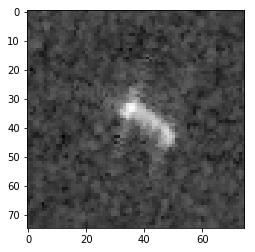

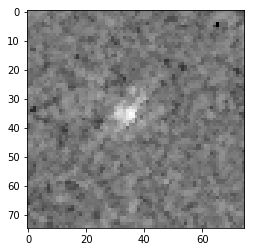

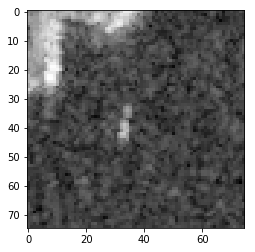

In [14]:
hh_channel, hv_channel = get_image_channels(X_train_initial, 24)
display_image(hh_channel)

hh_channel, hv_channel = get_image_channels(X_train_initial, 25)
display_image(hh_channel)

hh_channel, hv_channel = get_image_channels(X_train_initial, 26)
display_image(hh_channel)

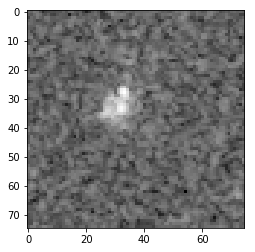

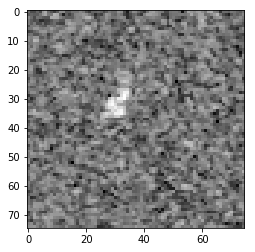

1


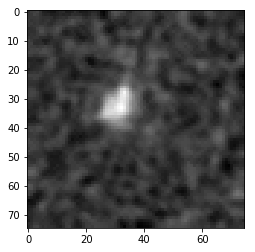

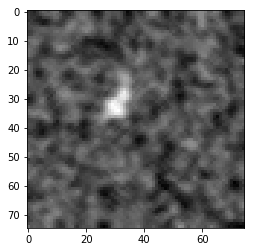

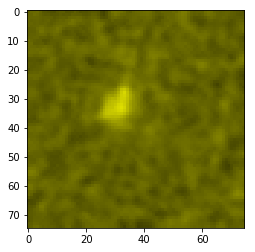

In [15]:
index = 1250

hh_image, hv_image =  get_image_channels(X_train_initial, index)
display_image(hh_image)
display_image(hv_image)

print(y_train_initial[index])

import cv2

hh_image = cv2.bilateralFilter(hh_image.astype(np.float32), 5, 80, 80)
hv_image = cv2.bilateralFilter(hv_image.astype(np.float32), 5, 80, 80)

display_image(hh_image)
display_image(hv_image)


image = np.dstack((hh_image, hh_image, np.zeros_like(hv_image)))
plt.imshow(image)
plt.show()

## Simple classifiers

In [16]:
import cv2

def process(image):
    image = local_min_max_scale_sar_image(image)
    return image
    
ptocessing_lambda = lambda image: process(image)
ptocessing_angle_lambda = lambda angle: 1.0 - (angle_max - angle) / (angle_max - angle_min)

X_flat_initial, y_flat_initial, _ = prepare_flat_dataset_with_angles(train_data, ptocessing_lambda, ptocessing_angle_lambda)

print('Training dataset size: {}'.format(len(X_flat_initial)))

Training dataset size: 1471


#### Split initial dataset to training and validation set

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_flat_initial, y_flat_initial, test_size=0.2, random_state=42)

print('Final training dataset size: {}'.format(len(X_train)))
print('Final validation dataset size: {}'.format(len(X_valid)))

Final training dataset size: 1176
Final validation dataset size: 295


In [18]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree  import DecisionTreeClassifier

from time import time
import json

clf1= LogisticRegression(random_state = 3)
clf2 = AdaBoostClassifier(random_state = 3)
clf3 = SVC(random_state = 3)
clf4 = DecisionTreeClassifier(random_state = 3)

from sklearn.metrics import log_loss, accuracy_score 

def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    results = {}
    
    start = time() # Get start time
  
    learner.fit(X_train, y_train)
    
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    X_train_pred = X_train[:300]
    y_train_pred = y_train[:300]
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train_pred)
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train_pred, predictions_train)
    results['log_loss_train'] = log_loss(y_train_pred, predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    results['log_loss_test'] = log_loss(y_test, predictions_test)
       
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, len(X_train)))
        
    # Return the results
    return results

print(train_predict(clf1, X_train, y_train, X_valid, y_valid))
print(train_predict(clf2, X_train, y_train, X_valid, y_valid))
print(train_predict(clf3, X_train, y_train, X_valid, y_valid))


LogisticRegression trained on 1176 samples.
{'train_time': 2.3636345863342285, 'log_loss_train': 9.9920072216264148e-16, 'pred_time': 0.011500120162963867, 'acc_train': 1.0, 'log_loss_test': 6.9078393044748019, 'acc_test': 0.80000000000000004}
AdaBoostClassifier trained on 1176 samples.
{'train_time': 56.3687481880188, 'log_loss_train': 1.3815643824202646, 'pred_time': 0.19403505325317383, 'acc_train': 0.95999999999999996, 'log_loss_test': 8.3128281638591055, 'acc_test': 0.7593220338983051}
SVC trained on 1176 samples.
{'train_time': 12.975327014923096, 'log_loss_train': 8.9802097982656104, 'pred_time': 6.013159990310669, 'acc_train': 0.73999999999999999, 'log_loss_test': 8.898258258600988, 'acc_test': 0.74237288135593216}


In [19]:
from sklearn.grid_search import GridSearchCV 
from sklearn.metrics import fbeta_score, make_scorer

dtc = DecisionTreeClassifier(random_state = 3)

clf_default = AdaBoostClassifier(random_state = 3, base_estimator = dtc) 
clf = AdaBoostClassifier(random_state = 3, base_estimator = dtc)

# TODO: Create the parameters list you wish to tune
parameters = { 'n_estimators': [5, 10, 20, 50, 100], \
              # 'base_estimator__criterion' : ['gini', 'entropy'], \
               'base_estimator__max_depth': [2, 3, 5, 10, None] \
             #  'base_estimator__min_samples_split': [2, 5, 10, 50], \
             #  'base_estimator__class_weight': [{ 1 : 0.75}, { 1 : 1}] 
             } 

scorer = make_scorer(log_loss, greater_is_better=False)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring = scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

C:\Users\Alexey\AppData\Local\conda\conda\envs\aind-cv\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Alexey\AppData\Local\conda\conda\envs\aind-cv\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


KeyboardInterrupt: 

In [19]:
def_model = clf_default.fit(X_train, y_train)

NameError: name 'clf_default' is not defined

In [ ]:
# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = def_model.predict(X_valid)
best_predictions = best_clf.predict(X_valid)

print ("Unoptimized model\n------")
print ("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_valid, predictions)))
print ("log_loss on testing data: {:.4f}".format(log_loss(y_valid, predictions)))

print ("\nOptimized Model\n------")
print ("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_valid, best_predictions)))
print ("Final log_loss on the testing data: {:.4f}".format(log_loss(y_valid, best_predictions)))
                                                                     
print (grid_fit.best_params_)

#### Split initial dataset to training and validation set

In [20]:
from sklearn.model_selection import train_test_split

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_train_initial, y_train_initial, test_size=0.05, random_state=142)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_1, y_train_1, test_size=0.33, random_state=42)

print('Final training dataset size: {}'.format(len(X_train)))
print('Final validation dataset size: {}'.format(len(X_valid)))
print('Final tet dataset size: {}'.format(len(X_test_1)))

Final training dataset size: 935
Final validation dataset size: 462
Final tet dataset size: 74


In [21]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=180, width_shift_range = 0.05, height_shift_range = 0.05, 
                             horizontal_flip = True, vertical_flip = True)
datagen.fit(X_train)

#X_train_new = np.copy(X_train)
#Y_train_new = np.copy(y_train)

#for i in range(40):
#    X_batch, y_batch =  next(datagen.flow(X_train, y_train, batch_size=2000))
#    if i == 0:
#        X_train_new = X_batch
#        Y_train_new = y_batch
#    else: 
#        X_train_new = np.concatenate((X_train_new, X_batch), axis=0)
#        Y_train_new = np.concatenate((Y_train_new, y_batch), axis=0)
    
    #plt.imshow(X_batch[24, :, :, 0])
    #plt.show()
                                    
    
#print(X_batch.shape)


#print (X_batch.shape)
##X_train = cut_image_part(X_train_new, 10)
#print (X_train_new.shape)







Using TensorFlow backend.


## Inception

In [ ]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model

base_model = InceptionV3(include_top=False, weights='imagenet')
model = Model(input=base_model.input, output=base_model.get_layer('avg_pool').output)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_initial, y_train_initial, test_size=0.2, random_state=42)

print('Final training dataset size: {}'.format(len(X_train)))
print('Final validation dataset size: {}'.format(len(X_valid)))

features_train = []
features_valid = []

for x in X_train:
    x = np.expand_dims(x, axis = 0)
    feature = model.predict(x)
    flat = feature.flatten()
    features_train.append(flat)

for x in X_valid:
    x = np.expand_dims(x, axis = 0)
    feature = model.predict(x)
    flat = feature.flatten()
    features_valid.append(flat)


In [ ]:
lrc = LogisticRegression(random_state = 3)
lrc = SVC(random_state = 3)

results = {}
    
start = time() # Get start time
lrc.fit(features_train, y_train)
end = time() # Get end time
results['train_time'] = end - start


start = time() # Get start time
predictions_test = lrc.predict(features_valid)
predictions_train = lrc.predict(features_train)
end = time() # Get end time
    
results['pred_time'] = end - start
results['acc_train'] = accuracy_score(y_train, predictions_train)
results['log_loss_train'] = log_loss(y_train, predictions_train)
results['acc_test'] = accuracy_score(y_valid, predictions_test)
results['log_loss_test'] = log_loss(y_valid, predictions_test)
       
print ("{} trained on {} samples.".format(lrc.__class__.__name__, len(features_train)))

results

## Model

In [22]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Activation, BatchNormalization
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import Flatten, Dense
from keras.initializers import RandomNormal
from keras.regularizers import l2

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model


entities_count = 20

def getModel10(num_layers):
    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same',
                    input_shape=(75, 75, num_layers), use_bias=True))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))
    return model

def getModel11(num_layers):
    model = Sequential()
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same',
                     input_shape=(75, 75, num_layers), use_bias=False))
    model.add(Activation('relu'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same',
                     input_shape=(75, 75, num_layers), use_bias=False))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
  
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Activation('relu'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Activation('relu'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Activation('relu'))
    model.add(Convolution2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(2048, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))

    return model
 


def getModel20(num_layers):
    activation = 'elu'
    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(2, 2), strides=(1, 1), padding='same',
                    input_shape=(75, 75, num_layers), use_bias=True))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=32, kernel_size=(2, 2), strides=(1, 1), padding='same', use_bias=True))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(2, 2), strides=(1, 1), padding='same', use_bias=True))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=128, kernel_size=(2, 2), strides=(1, 1), padding='same', use_bias=True))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(256, activation=activation))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation=activation))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))
    
    return model


def getTransferLearningModel():
    activation = 'elu'
    base_model = InceptionV3(include_top=False, weights='imagenet')
    output = base_model.output
    
    layer = GlobalMaxPooling2D()(output)
    layer = Dense(512, activation='relu', name='fc2')(layer)
    layer = Dropout(0.3)(layer)
    layer = Dense(512, activation='relu', name='fc3')(layer)
    layer = Dropout(0.3)(layer)
    predictions = Dense(1, activation='sigmoid')(layer)
   
    model = Model(input=base_model.input, output=predictions)
  
    return model

In [23]:
def getModel30(num_layers):
    activation = 'elu'
    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same',
                    input_shape=(75, 75, num_layers), use_bias=True,
                    kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(2048, activation=activation,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Dropout(0.4))
    model.add(Dense(1024, activation=activation,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation=activation,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))
    
    return model

def getModel32(num_layers):
    activation = 'elu'
    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same',
                    input_shape=(75, 75, num_layers), use_bias=True,
                    kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                    kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                    kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
 

    
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    
    
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    
    
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    
    
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(GlobalMaxPooling2D())
    model.add(Dense(1, activation="sigmoid"))
    
    
    return model

def getModel31(num_layers):
    activation = 'relu'
    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same',
                    input_shape=(75, 75, num_layers), use_bias=True,
                    kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(Convolution2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                    kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(2048, activation=activation,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Dropout(0.4))
    model.add(Dense(1024, activation=activation,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation=activation,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))
    
    return model

def getModel40(num_layers):
    model = Sequential()
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same',
                     input_shape=(75, 75, num_layers), use_bias=False,
                     kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None), kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None), kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None), kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None), kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None), kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None), kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(1024, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None), kernel_regularizer=l2(0.1)))
    model.add(Dropout(0.3))
    model.add(Dense(1024, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None), kernel_regularizer=l2(0.1)))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None), kernel_regularizer=l2(0.1)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))

    return model



def getModel50(num_layers):
    model = Sequential()
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same',
                     input_shape=(75, 75, num_layers), use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same',
                     input_shape=(75, 75, num_layers), use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(1024, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))

    return model

In [24]:
model = getModel11(3)
#model = getTransferLearningModel()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 75, 64)        1728      
_________________________________________________________________
activation_1 (Activation)    (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        36864     
_________________________________________________________________
activation_2 (Activation)    (None, 75, 75, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 38, 38, 128)       73728     
_________________________________________________________________
activation_3 (Activation)    (None, 38, 38, 128)       0         
__________

In [27]:
batch_size = 256
epochs = 100

def init_model(model, file_name):
    checkpointer = ModelCheckpoint(filepath=file_name, verbose=1, save_best_only=True)
    
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
    optimizer_small = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0)
    optimizer2 = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


    return model, checkpointer

In [26]:
from keras.callbacks import ModelCheckpoint  
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

from sklearn.model_selection import train_test_split
from keras.models import load_model

#X_train_initial2 = X_train_initial[:,:,:, 1:3]
X_train, X_test, y_train, y_test = train_test_split(X_train_initial, y_train_initial, test_size=0.1, random_state=17)

print('Final training dataset size: {}'.format(len(X_train)))
print('Final test dataset size: {}'.format(len(X_test)))

K = 6
folds = list(StratifiedKFold(n_splits=K, shuffle=True, random_state=129).split(X_train, y_train))

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=0, width_shift_range = 0, height_shift_range = 0, 
                             horizontal_flip = True, vertical_flip = True)

#res = model.fit(train_tensors, train_targets, 
#          validation_data = (X_valid, y_valid),
#          epochs=epochs, batch_size=64, callbacks=[checkpointer], verbose=1)
mean_loss = 0

for i, (train_idx, valid_idx) in enumerate(folds):
    print("Fold: {}".format(i))
    file_name = 'saved_models/fold{}.weights.best.from_scratch.hdf5'.format(i)

    model, checkpointer = init_model(getModel11(3), file_name)
    
    X_train_ = X_train[train_idx]
    y_train_ = y_train[train_idx]
    X_valid_ = X_train[valid_idx]
    y_valid_ =  y_train[valid_idx]

    datagen.fit(X_train_)

    res = model.fit_generator(datagen.flow(X_train_, y_train_, batch_size=batch_size),  steps_per_epoch=len(X_train) / batch_size, epochs=epochs, validation_data = (X_valid_, y_valid_), verbose=1, callbacks=[checkpointer])
    
    
    prediction_model = load_model(file_name )
    
    test_score = prediction_model.evaluate(X_test, y_test)
 
    print('Test loss:', test_score[0])
    print('Test accuracy:', test_score[1])
    
    mean_loss += test_score[0] / K
        
#res = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
#                    steps_per_epoch=len(X_train) / batch_size, epochs=epochs, validation_data = (X_valid, y_valid), verbose=1, callbacks=[checkpointer])

print('Mean loss:',   mean_loss)

Final training dataset size: 1323
Final test dataset size: 148
Fold: 0
Epoch 1/150
11/10 [===============================] - 66s - loss: 0.7071 - acc: 0.4735 - val_loss: 0.6932 - val_acc: 0.4887
Epoch 2/150
11/10 [===============================] - 4s - loss: 0.7570 - acc: 0.5176 - val_loss: 0.6909 - val_acc: 0.5113
Epoch 3/150
11/10 [===============================] - 1s - loss: 0.6924 - acc: 0.4989 - val_loss: 0.6937 - val_acc: 0.4887
Epoch 4/150
11/10 [===============================] - 1s - loss: 0.6936 - acc: 0.4870 - val_loss: 0.6931 - val_acc: 0.4887
Epoch 5/150
11/10 [===============================] - 1s - loss: 0.6930 - acc: 0.5060 - val_loss: 0.6920 - val_acc: 0.5714
Epoch 6/150
11/10 [===============================] - 4s - loss: 0.6741 - acc: 0.6008 - val_loss: 0.6217 - val_acc: 0.6466
Epoch 7/150
11/10 [===============================] - 1s - loss: 0.6440 - acc: 0.6409 - val_loss: 0.6303 - val_acc: 0.6316
Epoch 8/150
11/10 [===============================] - 3s - loss: 0.

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178531). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.355059). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 5s - loss: 0.6032 - acc: 0.6910 - val_loss: 0.5792 - val_acc: 0.6992
Epoch 21/150
11/10 [===============================] - 1s - loss: 0.5922 - acc: 0.6938 - val_loss: 0.6066 - val_acc: 0.6767
Epoch 22/150
11/10 [===============================] - 1s - loss: 0.5907 - acc: 0.6901 - val_loss: 0.5889 - val_acc: 0.6767
Epoch 23/150
11/10 [===============================] - 4s - loss: 0.5764 - acc: 0.7058 - val_loss: 0.5429 - val_acc: 0.7669
Epoch 24/150
11/10 [===============================] - 4s - loss: 0.5438 - acc: 0.7312 - val_loss: 0.5075 - val_acc: 0.8045
Epoch 25/150
11/10 [===============================] - 4s - loss: 0.5459 - acc: 0.7446 - val_loss: 0.4987 - val_acc: 0.7744
Epoch 26/150
11/10 [===============================] - 4s - loss: 0.5234 - acc: 0.7641 - val_loss: 0.4889 - val_acc: 0.7820
Epoch 27/150
11/10 [===============================] - 5s - loss: 0.5196 - acc: 0.7745 - val_loss: 0.4426 - val_acc: 0.8045
Epoch 28/150
11/10 [=

11/10 [===============================] - 4s - loss: 0.3130 - acc: 0.8604 - val_loss: 0.2964 - val_acc: 0.8571
Epoch 49/150
11/10 [===============================] - 1s - loss: 0.3220 - acc: 0.8679 - val_loss: 0.3489 - val_acc: 0.8045
Epoch 50/150
11/10 [===============================] - 1s - loss: 0.3158 - acc: 0.8611 - val_loss: 0.3514 - val_acc: 0.8195
Epoch 51/150
11/10 [===============================] - 4s - loss: 0.3120 - acc: 0.8616 - val_loss: 0.2932 - val_acc: 0.8496
Epoch 52/150
11/10 [===============================] - 1s - loss: 0.2809 - acc: 0.8721 - val_loss: 0.3057 - val_acc: 0.8346
Epoch 53/150
11/10 [===============================] - 1s - loss: 0.2613 - acc: 0.8736 - val_loss: 0.3069 - val_acc: 0.8496
Epoch 54/150
11/10 [===============================] - 1s - loss: 0.2689 - acc: 0.8752 - val_loss: 0.3960 - val_acc: 0.8346
Epoch 55/150
11/10 [===============================] - 4s - loss: 0.2686 - acc: 0.8829 - val_loss: 0.2851 - val_acc: 0.8571
Epoch 56/150
11/10 [=

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.510239). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.255871). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 2s - loss: 0.1755 - acc: 0.9183 - val_loss: 0.2320 - val_acc: 0.8947
Epoch 80/150
11/10 [===============================] - 1s - loss: 0.1920 - acc: 0.9141 - val_loss: 0.2539 - val_acc: 0.8872
Epoch 81/150
11/10 [===============================] - 1s - loss: 0.1698 - acc: 0.9269 - val_loss: 0.3431 - val_acc: 0.8722
Epoch 82/150
11/10 [===============================] - 1s - loss: 0.1843 - acc: 0.9136 - val_loss: 0.2594 - val_acc: 0.8797
Epoch 83/150
11/10 [===============================] - 1s - loss: 0.1620 - acc: 0.9318 - val_loss: 0.2342 - val_acc: 0.8872
Epoch 84/150
11/10 [===============================] - 1s - loss: 0.1507 - acc: 0.9345 - val_loss: 0.2278 - val_acc: 0.9098
Epoch 85/150
11/10 [===============================] - 1s - loss: 0.1423 - acc: 0.9356 - val_loss: 0.2849 - val_acc: 0.8947
Epoch 86/150
11/10 [===============================] - 1s - loss: 0.1289 - acc: 0.9412 - val_loss: 0.3199 - val_acc: 0.8797
Epoch 87/150
11/10 [=

11/10 [===============================] - 1s - loss: 0.0959 - acc: 0.9621 - val_loss: 0.3267 - val_acc: 0.8947
Epoch 114/150
11/10 [===============================] - 1s - loss: 0.1040 - acc: 0.9650 - val_loss: 0.3396 - val_acc: 0.8797
Epoch 115/150
11/10 [===============================] - 1s - loss: 0.1161 - acc: 0.9520 - val_loss: 0.4387 - val_acc: 0.8722
Epoch 116/150
11/10 [===============================] - 1s - loss: 0.0930 - acc: 0.9656 - val_loss: 0.3689 - val_acc: 0.8797
Epoch 117/150
11/10 [===============================] - 1s - loss: 0.0783 - acc: 0.9720 - val_loss: 0.2891 - val_acc: 0.9098
Epoch 118/150
11/10 [===============================] - 1s - loss: 0.0877 - acc: 0.9639 - val_loss: 0.3349 - val_acc: 0.8947
Epoch 119/150
11/10 [===============================] - 1s - loss: 0.0657 - acc: 0.9750 - val_loss: 0.2787 - val_acc: 0.9098
Epoch 120/150
11/10 [===============================] - 1s - loss: 0.0837 - acc: 0.9637 - val_loss: 0.3259 - val_acc: 0.9023
Epoch 121/150


C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.675543). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.338523). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 2s - loss: 0.0530 - acc: 0.9812 - val_loss: 0.3563 - val_acc: 0.8947
Epoch 140/150
11/10 [===============================] - 1s - loss: 0.0463 - acc: 0.9835 - val_loss: 0.4720 - val_acc: 0.8947
Epoch 141/150
11/10 [===============================] - 1s - loss: 0.0396 - acc: 0.9885 - val_loss: 0.4557 - val_acc: 0.9098
Epoch 142/150
11/10 [===============================] - 1s - loss: 0.0806 - acc: 0.9756 - val_loss: 0.4122 - val_acc: 0.8872
Epoch 143/150
11/10 [===============================] - 1s - loss: 0.0739 - acc: 0.9735 - val_loss: 0.3692 - val_acc: 0.8872
Epoch 144/150
11/10 [===============================] - 1s - loss: 0.1170 - acc: 0.9699 - val_loss: 0.5071 - val_acc: 0.8722
Epoch 145/150
11/10 [===============================] - 1s - loss: 0.1003 - acc: 0.9538 - val_loss: 0.4090 - val_acc: 0.8496
Epoch 146/150
11/10 [===============================] - 1s - loss: 0.1266 - acc: 0.9479 - val_loss: 0.3659 - val_acc: 0.8797
Epoch 147/150


C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.592237). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.297118). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 4s - loss: 0.6574 - acc: 0.5883 - val_loss: 0.5885 - val_acc: 0.6541
Epoch 9/150
11/10 [===============================] - 4s - loss: 0.6152 - acc: 0.6590 - val_loss: 0.5844 - val_acc: 0.6692
Epoch 10/150
11/10 [===============================] - 1s - loss: 0.6300 - acc: 0.6450 - val_loss: 0.5957 - val_acc: 0.6692
Epoch 11/150
11/10 [===============================] - 1s - loss: 0.6220 - acc: 0.6464 - val_loss: 0.5959 - val_acc: 0.6541
Epoch 12/150
11/10 [===============================] - 1s - loss: 0.6294 - acc: 0.6321 - val_loss: 0.6313 - val_acc: 0.5940
Epoch 13/150
11/10 [===============================] - 1s - loss: 0.6641 - acc: 0.6302 - val_loss: 0.6827 - val_acc: 0.5865
Epoch 14/150
11/10 [===============================] - 4s - loss: 0.6638 - acc: 0.6188 - val_loss: 0.5747 - val_acc: 0.6617
Epoch 15/150
11/10 [===============================] - 1s - loss: 0.6334 - acc: 0.6498 - val_loss: 0.6105 - val_acc: 0.6692
Epoch 16/150
11/10 [==

11/10 [===============================] - 1s - loss: 0.4048 - acc: 0.8205 - val_loss: 0.3452 - val_acc: 0.8496
Epoch 38/150
11/10 [===============================] - 4s - loss: 0.3965 - acc: 0.8086 - val_loss: 0.3080 - val_acc: 0.8797
Epoch 39/150
11/10 [===============================] - 1s - loss: 0.4248 - acc: 0.7772 - val_loss: 0.3190 - val_acc: 0.8647
Epoch 40/150
11/10 [===============================] - 4s - loss: 0.3813 - acc: 0.8366 - val_loss: 0.2855 - val_acc: 0.8872
Epoch 41/150
11/10 [===============================] - 4s - loss: 0.3476 - acc: 0.8305 - val_loss: 0.2565 - val_acc: 0.8872
Epoch 42/150
 3/10 [=======>......................] - ETA: 2s - loss: 0.3085 - acc: 0.8750

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.468375). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.318710). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169044). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 4s - loss: 0.3319 - acc: 0.8466 - val_loss: 0.2501 - val_acc: 0.9023
Epoch 43/150
11/10 [===============================] - 1s - loss: 0.3448 - acc: 0.8387 - val_loss: 0.2732 - val_acc: 0.8947
Epoch 44/150
11/10 [===============================] - 4s - loss: 0.3044 - acc: 0.8530 - val_loss: 0.2411 - val_acc: 0.8947
Epoch 45/150
11/10 [===============================] - 1s - loss: 0.3293 - acc: 0.8477 - val_loss: 0.2741 - val_acc: 0.8797
Epoch 46/150
11/10 [===============================] - 4s - loss: 0.3147 - acc: 0.8471 - val_loss: 0.1908 - val_acc: 0.9248
Epoch 47/150
11/10 [===============================] - 1s - loss: 0.3137 - acc: 0.8443 - val_loss: 0.2143 - val_acc: 0.9398
Epoch 48/150
11/10 [===============================] - 1s - loss: 0.3044 - acc: 0.8637 - val_loss: 0.1973 - val_acc: 0.9098
Epoch 49/150
11/10 [===============================] - 1s - loss: 0.2847 - acc: 0.8611 - val_loss: 0.2141 - val_acc: 0.9173
Epoch 50/150
11/10 [=

11/10 [===============================] - 2s - loss: 0.2070 - acc: 0.9068 - val_loss: 0.1830 - val_acc: 0.9098
Epoch 74/150
 2/10 [====>.........................] - ETA: 3s - loss: 0.1609 - acc: 0.9336

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.450933). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229468). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 2s - loss: 0.1906 - acc: 0.9161 - val_loss: 0.2518 - val_acc: 0.8947
Epoch 75/150
11/10 [===============================] - 1s - loss: 0.2010 - acc: 0.9103 - val_loss: 0.2239 - val_acc: 0.9098
Epoch 76/150
11/10 [===============================] - 1s - loss: 0.1790 - acc: 0.9235 - val_loss: 0.2459 - val_acc: 0.9098
Epoch 77/150
11/10 [===============================] - 1s - loss: 0.1808 - acc: 0.9145 - val_loss: 0.2226 - val_acc: 0.9098
Epoch 78/150
11/10 [===============================] - 1s - loss: 0.1768 - acc: 0.9198 - val_loss: 0.2104 - val_acc: 0.9173
Epoch 79/150
11/10 [===============================] - 1s - loss: 0.2356 - acc: 0.8947 - val_loss: 0.2325 - val_acc: 0.8571
Epoch 80/150
11/10 [===============================] - 1s - loss: 0.2118 - acc: 0.8984 - val_loss: 0.2151 - val_acc: 0.9098
Epoch 81/150
11/10 [===============================] - 1s - loss: 0.1812 - acc: 0.9169 - val_loss: 0.2669 - val_acc: 0.9248
Epoch 82/150
11/10 [=

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.333947). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.646667). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.324333). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 3s - loss: 0.1643 - acc: 0.9275 - val_loss: 0.2092 - val_acc: 0.9173
Epoch 89/150
11/10 [===============================] - 1s - loss: 0.1522 - acc: 0.9341 - val_loss: 0.2693 - val_acc: 0.9023
Epoch 90/150
11/10 [===============================] - 1s - loss: 0.1727 - acc: 0.9211 - val_loss: 0.1925 - val_acc: 0.9098
Epoch 91/150
11/10 [===============================] - 1s - loss: 0.1521 - acc: 0.9339 - val_loss: 0.2141 - val_acc: 0.9248
Epoch 92/150
11/10 [===============================] - 1s - loss: 0.1440 - acc: 0.9421 - val_loss: 0.1713 - val_acc: 0.9398
Epoch 93/150
11/10 [===============================] - 1s - loss: 0.1826 - acc: 0.9217 - val_loss: 0.2184 - val_acc: 0.9173
Epoch 94/150
11/10 [===============================] - 1s - loss: 0.1844 - acc: 0.9210 - val_loss: 0.1836 - val_acc: 0.9173
Epoch 95/150
11/10 [===============================] - 1s - loss: 0.1645 - acc: 0.9276 - val_loss: 0.2518 - val_acc: 0.9098
Epoch 96/150
11/10 [=

11/10 [===============================] - 1s - loss: 0.0964 - acc: 0.9592 - val_loss: 0.2475 - val_acc: 0.9248
Epoch 123/150
11/10 [===============================] - 1s - loss: 0.1400 - acc: 0.9443 - val_loss: 0.3488 - val_acc: 0.8647
Epoch 124/150
11/10 [===============================] - 1s - loss: 0.1659 - acc: 0.9217 - val_loss: 0.1842 - val_acc: 0.9398
Epoch 125/150
11/10 [===============================] - 1s - loss: 0.0955 - acc: 0.9620 - val_loss: 0.2535 - val_acc: 0.9549
Epoch 126/150
11/10 [===============================] - 1s - loss: 0.0965 - acc: 0.9595 - val_loss: 0.2864 - val_acc: 0.9248
Epoch 127/150
11/10 [===============================] - 1s - loss: 0.1288 - acc: 0.9489 - val_loss: 0.2556 - val_acc: 0.9173
Epoch 128/150
11/10 [===============================] - 1s - loss: 0.1041 - acc: 0.9582 - val_loss: 0.2948 - val_acc: 0.9173
Epoch 129/150
11/10 [===============================] - 2s - loss: 0.0866 - acc: 0.9650 - val_loss: 0.2498 - val_acc: 0.9248
Epoch 130/150


11/10 [===============================] - 4s - loss: 0.6792 - acc: 0.5574 - val_loss: 0.6644 - val_acc: 0.6466
Epoch 5/150
11/10 [===============================] - 1s - loss: 0.6815 - acc: 0.6296 - val_loss: 0.6837 - val_acc: 0.5639
Epoch 6/150
11/10 [===============================] - 4s - loss: 0.6467 - acc: 0.6139 - val_loss: 0.6527 - val_acc: 0.6466
Epoch 7/150
11/10 [===============================] - 1s - loss: 0.6435 - acc: 0.6391 - val_loss: 0.8492 - val_acc: 0.6316
Epoch 8/150
11/10 [===============================] - 4s - loss: 0.6318 - acc: 0.6664 - val_loss: 0.6402 - val_acc: 0.6767
Epoch 9/150
11/10 [===============================] - 4s - loss: 0.6014 - acc: 0.6834 - val_loss: 0.6193 - val_acc: 0.7143
Epoch 10/150
11/10 [===============================] - 4s - loss: 0.5935 - acc: 0.7229 - val_loss: 0.5744 - val_acc: 0.7594
Epoch 11/150
11/10 [===============================] - 4s - loss: 0.5506 - acc: 0.7326 - val_loss: 0.5552 - val_acc: 0.7293
Epoch 12/150
11/10 [======

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.263014). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237922). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212830). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 4s - loss: 0.3976 - acc: 0.8314 - val_loss: 0.4388 - val_acc: 0.8045
Epoch 19/150
11/10 [===============================] - 4s - loss: 0.3650 - acc: 0.8465 - val_loss: 0.4317 - val_acc: 0.8120
Epoch 20/150
11/10 [===============================] - 1s - loss: 0.4114 - acc: 0.8220 - val_loss: 0.4596 - val_acc: 0.8120
Epoch 21/150
11/10 [===============================] - 1s - loss: 0.3634 - acc: 0.8480 - val_loss: 0.4326 - val_acc: 0.7970
Epoch 22/150
11/10 [===============================] - 4s - loss: 0.3572 - acc: 0.8414 - val_loss: 0.4212 - val_acc: 0.8271
Epoch 23/150
11/10 [===============================] - 1s - loss: 0.3146 - acc: 0.8691 - val_loss: 0.4555 - val_acc: 0.8195
Epoch 24/150
11/10 [===============================] - 1s - loss: 0.3052 - acc: 0.8668 - val_loss: 0.4579 - val_acc: 0.8271
Epoch 25/150
11/10 [===============================] - 4s - loss: 0.3461 - acc: 0.8518 - val_loss: 0.4110 - val_acc: 0.8346
Epoch 26/150
11/10 [=

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.747078). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.628525). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.509971). Check your callbacks.
  % delta_t_median)


 5/10 [=============>................] - ETA: 2s - loss: 0.2323 - acc: 0.9096

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.255986). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 5s - loss: 0.2729 - acc: 0.8830 - val_loss: 0.3600 - val_acc: 0.8571
Epoch 38/150
11/10 [===============================] - 4s - loss: 0.2620 - acc: 0.8783 - val_loss: 0.3512 - val_acc: 0.8346
Epoch 39/150
11/10 [===============================] - 1s - loss: 0.2183 - acc: 0.8938 - val_loss: 0.4483 - val_acc: 0.8120
Epoch 40/150
11/10 [===============================] - 1s - loss: 0.2783 - acc: 0.8632 - val_loss: 0.3826 - val_acc: 0.8195
Epoch 41/150
11/10 [===============================] - 1s - loss: 0.2688 - acc: 0.8835 - val_loss: 0.4147 - val_acc: 0.7970
Epoch 42/150
11/10 [===============================] - 1s - loss: 0.2266 - acc: 0.8975 - val_loss: 0.4184 - val_acc: 0.8421
Epoch 43/150
11/10 [===============================] - 1s - loss: 0.2005 - acc: 0.9083 - val_loss: 0.4098 - val_acc: 0.8195
Epoch 44/150
11/10 [===============================] - 1s - loss: 0.2048 - acc: 0.9118 - val_loss: 0.4064 - val_acc: 0.7970
Epoch 45/150
11/10 [=

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.315778). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.630555). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 3s - loss: 0.1616 - acc: 0.9291 - val_loss: 0.5132 - val_acc: 0.8496
Epoch 64/150
11/10 [===============================] - 1s - loss: 0.1580 - acc: 0.9312 - val_loss: 0.5394 - val_acc: 0.8195
Epoch 65/150
11/10 [===============================] - 1s - loss: 0.1623 - acc: 0.9268 - val_loss: 0.4724 - val_acc: 0.8722
Epoch 66/150
11/10 [===============================] - 1s - loss: 0.1508 - acc: 0.9355 - val_loss: 0.4953 - val_acc: 0.8346
Epoch 67/150
11/10 [===============================] - 1s - loss: 0.1317 - acc: 0.9398 - val_loss: 0.5011 - val_acc: 0.8346
Epoch 68/150
11/10 [===============================] - 1s - loss: 0.1651 - acc: 0.9287 - val_loss: 0.5912 - val_acc: 0.7895
Epoch 69/150
11/10 [===============================] - 1s - loss: 0.1758 - acc: 0.9167 - val_loss: 0.5022 - val_acc: 0.8271
Epoch 70/150
11/10 [===============================] - 1s - loss: 0.1295 - acc: 0.9399 - val_loss: 0.5478 - val_acc: 0.8195
Epoch 71/150
11/10 [=

11/10 [===============================] - 1s - loss: 0.1198 - acc: 0.9541 - val_loss: 0.7115 - val_acc: 0.7895
Epoch 98/150
11/10 [===============================] - 1s - loss: 0.1071 - acc: 0.9525 - val_loss: 0.8384 - val_acc: 0.8045
Epoch 99/150
11/10 [===============================] - 1s - loss: 0.0773 - acc: 0.9669 - val_loss: 0.8564 - val_acc: 0.8120
Epoch 100/150
11/10 [===============================] - 1s - loss: 0.0750 - acc: 0.9673 - val_loss: 0.8047 - val_acc: 0.8271
Epoch 101/150
11/10 [===============================] - 1s - loss: 0.0666 - acc: 0.9799 - val_loss: 0.7882 - val_acc: 0.8045
Epoch 102/150
11/10 [===============================] - 1s - loss: 0.0738 - acc: 0.9689 - val_loss: 1.0229 - val_acc: 0.8195
Epoch 103/150
11/10 [===============================] - 1s - loss: 0.0619 - acc: 0.9727 - val_loss: 0.8927 - val_acc: 0.7820
Epoch 104/150
11/10 [===============================] - 1s - loss: 0.0774 - acc: 0.9685 - val_loss: 1.0603 - val_acc: 0.8120
Epoch 105/150
11

11/10 [===============================] - 1s - loss: 0.0191 - acc: 0.9943 - val_loss: 1.2021 - val_acc: 0.8045
Epoch 132/150
11/10 [===============================] - 1s - loss: 0.0148 - acc: 0.9942 - val_loss: 1.2079 - val_acc: 0.8271
Epoch 133/150
11/10 [===============================] - 1s - loss: 0.0287 - acc: 0.9893 - val_loss: 1.2879 - val_acc: 0.8120
Epoch 134/150
11/10 [===============================] - 1s - loss: 0.0467 - acc: 0.9870 - val_loss: 1.2632 - val_acc: 0.8195
Epoch 135/150
 5/10 [=============>................] - ETA: 2s - loss: 0.0472 - acc: 0.9828

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209632). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 4s - loss: 0.0454 - acc: 0.9827 - val_loss: 0.8352 - val_acc: 0.8271
Epoch 136/150
11/10 [===============================] - 1s - loss: 0.0298 - acc: 0.9900 - val_loss: 1.1035 - val_acc: 0.7970
Epoch 137/150
11/10 [===============================] - 1s - loss: 0.0171 - acc: 0.9929 - val_loss: 1.1259 - val_acc: 0.8195
Epoch 138/150
11/10 [===============================] - 1s - loss: 0.0172 - acc: 0.9957 - val_loss: 1.0208 - val_acc: 0.8647
Epoch 139/150
11/10 [===============================] - 1s - loss: 0.0206 - acc: 0.9943 - val_loss: 1.1777 - val_acc: 0.7895
Epoch 140/150
11/10 [===============================] - 1s - loss: 0.0344 - acc: 0.9855 - val_loss: 1.2568 - val_acc: 0.7820
Epoch 141/150
11/10 [===============================] - 1s - loss: 0.0449 - acc: 0.9870 - val_loss: 0.8577 - val_acc: 0.8195
Epoch 142/150
11/10 [===============================] - 1s - loss: 0.0196 - acc: 0.9943 - val_loss: 0.7470 - val_acc: 0.8195
Epoch 143/150


C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.917206). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.459354). Check your callbacks.
  % delta_t_median)


128/148 [========================>.....] - ETA: 0sTest loss: 0.274270320261
Test accuracy: 0.885135136746
Fold: 3
Epoch 1/150
11/10 [===============================] - 7s - loss: 0.7045 - acc: 0.4752 - val_loss: 0.6606 - val_acc: 0.6165
Epoch 2/150
11/10 [===============================] - 1s - loss: 0.6941 - acc: 0.5420 - val_loss: 0.6930 - val_acc: 0.5113
Epoch 3/150
11/10 [===============================] - 1s - loss: 0.6931 - acc: 0.5020 - val_loss: 0.6930 - val_acc: 0.5113
Epoch 4/150
11/10 [===============================] - 1s - loss: 0.6920 - acc: 0.5205 - val_loss: 0.6938 - val_acc: 0.5113
Epoch 5/150
11/10 [===============================] - 1s - loss: 0.6913 - acc: 0.5071 - val_loss: 0.6916 - val_acc: 0.5113
Epoch 6/150
11/10 [===============================] - 1s - loss: 0.6899 - acc: 0.5063 - val_loss: 0.6896 - val_acc: 0.5113
Epoch 7/150
11/10 [===============================] - 1s - loss: 0.6802 - acc: 0.5485 - val_loss: 0.6836 - val_acc: 0.6241
Epoch 8/150
11/10 [======

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.843657). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.532359). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221062). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 5s - loss: 0.4099 - acc: 0.8329 - val_loss: 0.4745 - val_acc: 0.7744
Epoch 26/150
11/10 [===============================] - 4s - loss: 0.3998 - acc: 0.8291 - val_loss: 0.4299 - val_acc: 0.7970
Epoch 27/150
11/10 [===============================] - 4s - loss: 0.3709 - acc: 0.8458 - val_loss: 0.3737 - val_acc: 0.8195
Epoch 28/150
11/10 [===============================] - 4s - loss: 0.3685 - acc: 0.8477 - val_loss: 0.3697 - val_acc: 0.8271
Epoch 29/150
11/10 [===============================] - 1s - loss: 0.3675 - acc: 0.8429 - val_loss: 0.3790 - val_acc: 0.8120
Epoch 30/150
11/10 [===============================] - 4s - loss: 0.3598 - acc: 0.8422 - val_loss: 0.3579 - val_acc: 0.7970
Epoch 31/150
11/10 [===============================] - 1s - loss: 0.3397 - acc: 0.8530 - val_loss: 0.3796 - val_acc: 0.8120
Epoch 32/150
 3/10 [=======>......................] - ETA: 3s - loss: 0.3070 - acc: 0.8568

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.777591). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.542852). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.308114). Check your callbacks.
  % delta_t_median)


 5/10 [=============>................] - ETA: 2s - loss: 0.3069 - acc: 0.8547

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154557). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 5s - loss: 0.3235 - acc: 0.8517 - val_loss: 0.3543 - val_acc: 0.8271
Epoch 33/150
11/10 [===============================] - 1s - loss: 0.3170 - acc: 0.8478 - val_loss: 0.3770 - val_acc: 0.8271
Epoch 34/150
11/10 [===============================] - 4s - loss: 0.3345 - acc: 0.8522 - val_loss: 0.3003 - val_acc: 0.8195
Epoch 35/150
11/10 [===============================] - 4s - loss: 0.2729 - acc: 0.8781 - val_loss: 0.2674 - val_acc: 0.8872
Epoch 36/150
11/10 [===============================] - 1s - loss: 0.3329 - acc: 0.8495 - val_loss: 0.5913 - val_acc: 0.7293
Epoch 37/150
11/10 [===============================] - 1s - loss: 0.3127 - acc: 0.8711 - val_loss: 0.3317 - val_acc: 0.8421
Epoch 38/150
11/10 [===============================] - 1s - loss: 0.2961 - acc: 0.8670 - val_loss: 0.2728 - val_acc: 0.8797
Epoch 39/150
11/10 [===============================] - 1s - loss: 0.2681 - acc: 0.8773 - val_loss: 0.3300 - val_acc: 0.8421
Epoch 40/150
11/10 [=

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.442921). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221961). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 4s - loss: 0.2566 - acc: 0.8860 - val_loss: 0.2380 - val_acc: 0.9098
Epoch 42/150
11/10 [===============================] - 4s - loss: 0.2394 - acc: 0.8872 - val_loss: 0.2297 - val_acc: 0.9098
Epoch 43/150
11/10 [===============================] - 1s - loss: 0.2407 - acc: 0.8918 - val_loss: 0.2774 - val_acc: 0.8647
Epoch 44/150
11/10 [===============================] - 4s - loss: 0.2178 - acc: 0.8948 - val_loss: 0.2176 - val_acc: 0.9098
Epoch 45/150
11/10 [===============================] - 1s - loss: 0.2117 - acc: 0.9063 - val_loss: 0.2254 - val_acc: 0.9023
Epoch 46/150
11/10 [===============================] - 1s - loss: 0.2342 - acc: 0.8906 - val_loss: 0.2573 - val_acc: 0.8872
Epoch 47/150
11/10 [===============================] - 1s - loss: 0.2478 - acc: 0.8826 - val_loss: 0.3433 - val_acc: 0.8421
Epoch 48/150
11/10 [===============================] - 4s - loss: 0.2126 - acc: 0.9119 - val_loss: 0.2152 - val_acc: 0.9248
Epoch 49/150
11/10 [=

11/10 [===============================] - 1s - loss: 0.1678 - acc: 0.9122 - val_loss: 0.2556 - val_acc: 0.9098
Epoch 73/150
11/10 [===============================] - 3s - loss: 0.1785 - acc: 0.9147 - val_loss: 0.2356 - val_acc: 0.9248
Epoch 74/150
11/10 [===============================] - 1s - loss: 0.1337 - acc: 0.9421 - val_loss: 0.2378 - val_acc: 0.9098
Epoch 75/150
11/10 [===============================] - 1s - loss: 0.1298 - acc: 0.9361 - val_loss: 0.2310 - val_acc: 0.9248
Epoch 76/150
11/10 [===============================] - 1s - loss: 0.1642 - acc: 0.9245 - val_loss: 0.2257 - val_acc: 0.9023
Epoch 77/150
11/10 [===============================] - 1s - loss: 0.1278 - acc: 0.9442 - val_loss: 0.2224 - val_acc: 0.9023
Epoch 78/150
11/10 [===============================] - 1s - loss: 0.1346 - acc: 0.9427 - val_loss: 0.3846 - val_acc: 0.8722
Epoch 79/150
11/10 [===============================] - 1s - loss: 0.1936 - acc: 0.9187 - val_loss: 0.2087 - val_acc: 0.9248
Epoch 80/150
11/10 [=

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.310638). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.562756). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 2s - loss: 0.0644 - acc: 0.9763 - val_loss: 0.3605 - val_acc: 0.9173
Epoch 103/150
11/10 [===============================] - 1s - loss: 0.0721 - acc: 0.9692 - val_loss: 0.3746 - val_acc: 0.8947
Epoch 104/150
11/10 [===============================] - 1s - loss: 0.0432 - acc: 0.9850 - val_loss: 0.3847 - val_acc: 0.9173
Epoch 105/150
11/10 [===============================] - 1s - loss: 0.0550 - acc: 0.9814 - val_loss: 0.4604 - val_acc: 0.9098
Epoch 106/150
11/10 [===============================] - 1s - loss: 0.0423 - acc: 0.9864 - val_loss: 0.4566 - val_acc: 0.9023
Epoch 107/150
11/10 [===============================] - 1s - loss: 0.0777 - acc: 0.9677 - val_loss: 0.3780 - val_acc: 0.8872
Epoch 108/150
11/10 [===============================] - 1s - loss: 0.0941 - acc: 0.9620 - val_loss: 0.4261 - val_acc: 0.8872
Epoch 109/150
11/10 [===============================] - 1s - loss: 0.0621 - acc: 0.9704 - val_loss: 0.5580 - val_acc: 0.8872
Epoch 110/150


11/10 [===============================] - 1s - loss: 0.0527 - acc: 0.9829 - val_loss: 0.6080 - val_acc: 0.8947
Epoch 137/150
11/10 [===============================] - 1s - loss: 0.0808 - acc: 0.9630 - val_loss: 0.3835 - val_acc: 0.8947
Epoch 138/150
11/10 [===============================] - 1s - loss: 0.0487 - acc: 0.9820 - val_loss: 0.5317 - val_acc: 0.8797
Epoch 139/150
11/10 [===============================] - 1s - loss: 0.0204 - acc: 0.9957 - val_loss: 0.4705 - val_acc: 0.8947
Epoch 140/150
11/10 [===============================] - 1s - loss: 0.0202 - acc: 0.9919 - val_loss: 0.4909 - val_acc: 0.8872
Epoch 141/150
11/10 [===============================] - 1s - loss: 0.0134 - acc: 0.9957 - val_loss: 0.6492 - val_acc: 0.8947
Epoch 142/150
11/10 [===============================] - 1s - loss: 0.0170 - acc: 0.9950 - val_loss: 0.6633 - val_acc: 0.8947
Epoch 143/150
11/10 [===============================] - 1s - loss: 0.0157 - acc: 0.9935 - val_loss: 0.6332 - val_acc: 0.8647
Epoch 144/150


C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.414987). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208494). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 2s - loss: 0.6936 - acc: 0.4793 - val_loss: 0.6933 - val_acc: 0.4887
Epoch 3/150
11/10 [===============================] - 1s - loss: 0.6915 - acc: 0.5300 - val_loss: 0.6861 - val_acc: 0.5113
Epoch 4/150
11/10 [===============================] - 4s - loss: 0.6861 - acc: 0.5968 - val_loss: 0.6519 - val_acc: 0.6090
Epoch 5/150
11/10 [===============================] - 1s - loss: 0.6822 - acc: 0.5768 - val_loss: 0.6805 - val_acc: 0.5489
Epoch 6/150
11/10 [===============================] - 4s - loss: 0.6664 - acc: 0.6001 - val_loss: 0.6511 - val_acc: 0.5865
Epoch 7/150
11/10 [===============================] - 1s - loss: 0.6485 - acc: 0.6163 - val_loss: 0.6666 - val_acc: 0.6617
Epoch 8/150
11/10 [===============================] - 4s - loss: 0.5884 - acc: 0.6783 - val_loss: 0.5986 - val_acc: 0.6541
Epoch 9/150
11/10 [===============================] - 4s - loss: 0.5676 - acc: 0.7014 - val_loss: 0.5864 - val_acc: 0.6992
Epoch 10/150
11/10 [========

11/10 [===============================] - 4s - loss: 0.2863 - acc: 0.8785 - val_loss: 0.3386 - val_acc: 0.8195
Epoch 33/150
11/10 [===============================] - 1s - loss: 0.2515 - acc: 0.8918 - val_loss: 0.4158 - val_acc: 0.8271
Epoch 34/150
11/10 [===============================] - 4s - loss: 0.2776 - acc: 0.8739 - val_loss: 0.3016 - val_acc: 0.8271
Epoch 35/150
11/10 [===============================] - 1s - loss: 0.2762 - acc: 0.8917 - val_loss: 0.3437 - val_acc: 0.8195
Epoch 36/150
11/10 [===============================] - 1s - loss: 0.2533 - acc: 0.8880 - val_loss: 0.3515 - val_acc: 0.8496
Epoch 37/150
11/10 [===============================] - 4s - loss: 0.2505 - acc: 0.8950 - val_loss: 0.2917 - val_acc: 0.8647
Epoch 38/150
11/10 [===============================] - 1s - loss: 0.2334 - acc: 0.9018 - val_loss: 0.3123 - val_acc: 0.8496
Epoch 39/150
11/10 [===============================] - 1s - loss: 0.1941 - acc: 0.9155 - val_loss: 0.2931 - val_acc: 0.8271
Epoch 40/150
11/10 [=

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.447723). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.601536). Check your callbacks.
  % delta_t_median)


 5/10 [=============>................] - ETA: 2s - loss: 0.1635 - acc: 0.9313

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224862). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 3s - loss: 0.1888 - acc: 0.9156 - val_loss: 0.3117 - val_acc: 0.8722
Epoch 53/150
11/10 [===============================] - 1s - loss: 0.1882 - acc: 0.9185 - val_loss: 0.3277 - val_acc: 0.8496
Epoch 54/150
11/10 [===============================] - 1s - loss: 0.1749 - acc: 0.9213 - val_loss: 0.3443 - val_acc: 0.8496
Epoch 55/150
11/10 [===============================] - 1s - loss: 0.1773 - acc: 0.9280 - val_loss: 0.3400 - val_acc: 0.8346
Epoch 56/150
11/10 [===============================] - 1s - loss: 0.1694 - acc: 0.9319 - val_loss: 0.3331 - val_acc: 0.8195
Epoch 57/150
11/10 [===============================] - 1s - loss: 0.1744 - acc: 0.9319 - val_loss: 0.3642 - val_acc: 0.8346
Epoch 58/150
11/10 [===============================] - 1s - loss: 0.1559 - acc: 0.9342 - val_loss: 0.3054 - val_acc: 0.8421
Epoch 59/150
11/10 [===============================] - 1s - loss: 0.1499 - acc: 0.9398 - val_loss: 0.4255 - val_acc: 0.8421
Epoch 60/150
11/10 [=

11/10 [===============================] - 1s - loss: 0.0758 - acc: 0.9707 - val_loss: 0.5808 - val_acc: 0.8571
Epoch 87/150
11/10 [===============================] - 1s - loss: 0.1136 - acc: 0.9513 - val_loss: 0.4735 - val_acc: 0.8045
Epoch 88/150
11/10 [===============================] - 1s - loss: 0.1057 - acc: 0.9549 - val_loss: 0.4310 - val_acc: 0.8722
Epoch 89/150
11/10 [===============================] - 1s - loss: 0.0938 - acc: 0.9625 - val_loss: 0.4014 - val_acc: 0.8722
Epoch 90/150
11/10 [===============================] - 1s - loss: 0.0744 - acc: 0.9682 - val_loss: 0.4824 - val_acc: 0.8571
Epoch 91/150
11/10 [===============================] - 1s - loss: 0.0658 - acc: 0.9777 - val_loss: 0.5895 - val_acc: 0.8421
Epoch 92/150
11/10 [===============================] - 1s - loss: 0.0628 - acc: 0.9757 - val_loss: 0.6917 - val_acc: 0.8271
Epoch 93/150
11/10 [===============================] - 1s - loss: 0.0845 - acc: 0.9635 - val_loss: 0.6061 - val_acc: 0.8571
Epoch 94/150
11/10 [=

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199080). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 2s - loss: 0.1069 - acc: 0.9539 - val_loss: 0.4834 - val_acc: 0.8271
Epoch 96/150
11/10 [===============================] - 1s - loss: 0.0945 - acc: 0.9620 - val_loss: 0.6217 - val_acc: 0.8271
Epoch 97/150
11/10 [===============================] - 1s - loss: 0.0714 - acc: 0.9757 - val_loss: 0.6318 - val_acc: 0.8571
Epoch 98/150
11/10 [===============================] - 1s - loss: 0.0867 - acc: 0.9669 - val_loss: 0.5970 - val_acc: 0.8346
Epoch 99/150
11/10 [===============================] - 1s - loss: 0.0987 - acc: 0.9635 - val_loss: 0.4931 - val_acc: 0.8797
Epoch 100/150
11/10 [===============================] - 1s - loss: 0.0798 - acc: 0.9725 - val_loss: 0.5206 - val_acc: 0.8571
Epoch 101/150
11/10 [===============================] - 1s - loss: 0.0477 - acc: 0.9827 - val_loss: 0.7927 - val_acc: 0.8496
Epoch 102/150
11/10 [===============================] - 1s - loss: 0.0604 - acc: 0.9841 - val_loss: 0.6981 - val_acc: 0.8496
Epoch 103/150
11/1

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201402). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 2s - loss: 0.0116 - acc: 0.9979 - val_loss: 1.1156 - val_acc: 0.8722
Epoch 125/150
11/10 [===============================] - 3s - loss: 0.0282 - acc: 0.9899 - val_loss: 0.8219 - val_acc: 0.8346
Epoch 126/150
11/10 [===============================] - 1s - loss: 0.0139 - acc: 0.9957 - val_loss: 0.8844 - val_acc: 0.8797
Epoch 127/150
11/10 [===============================] - 1s - loss: 0.0230 - acc: 0.9885 - val_loss: 0.7871 - val_acc: 0.8872
Epoch 128/150
11/10 [===============================] - 1s - loss: 0.0462 - acc: 0.9813 - val_loss: 0.8084 - val_acc: 0.8571
Epoch 129/150
11/10 [===============================] - 1s - loss: 0.0220 - acc: 0.9914 - val_loss: 0.8032 - val_acc: 0.8496
Epoch 130/150
11/10 [===============================] - 1s - loss: 0.0290 - acc: 0.9913 - val_loss: 1.1431 - val_acc: 0.8045
Epoch 131/150
11/10 [===============================] - 1s - loss: 0.0607 - acc: 0.9785 - val_loss: 0.5962 - val_acc: 0.8797
Epoch 132/150


11/10 [===============================] - 4s - loss: 0.6691 - acc: 0.6057 - val_loss: 0.6256 - val_acc: 0.7348
Epoch 7/150
 4/10 [==========>...................] - ETA: 2s - loss: 0.6811 - acc: 0.6734

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225814). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.449627). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 5s - loss: 0.6541 - acc: 0.6406 - val_loss: 0.5899 - val_acc: 0.7121
Epoch 8/150
11/10 [===============================] - 1s - loss: 0.6351 - acc: 0.6405 - val_loss: 0.5922 - val_acc: 0.6667
Epoch 9/150
11/10 [===============================] - 4s - loss: 0.6078 - acc: 0.6658 - val_loss: 0.5794 - val_acc: 0.7273
Epoch 10/150
11/10 [===============================] - 4s - loss: 0.5898 - acc: 0.6897 - val_loss: 0.5756 - val_acc: 0.7045
Epoch 11/150
11/10 [===============================] - 4s - loss: 0.5842 - acc: 0.6965 - val_loss: 0.4771 - val_acc: 0.7879
Epoch 12/150
11/10 [===============================] - 1s - loss: 0.5774 - acc: 0.7002 - val_loss: 0.5560 - val_acc: 0.7803
Epoch 13/150
11/10 [===============================] - 1s - loss: 0.5460 - acc: 0.7195 - val_loss: 0.4824 - val_acc: 0.7576
Epoch 14/150
11/10 [===============================] - 1s - loss: 0.5239 - acc: 0.7509 - val_loss: 0.5299 - val_acc: 0.7348
Epoch 15/150
11/10 [===

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.303125). Check your callbacks.
  % delta_t_median)


 3/10 [=======>......................] - ETA: 2s - loss: 0.2946 - acc: 0.8594

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227060). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 3s - loss: 0.2637 - acc: 0.8821 - val_loss: 0.3613 - val_acc: 0.8333
Epoch 35/150
11/10 [===============================] - 1s - loss: 0.2606 - acc: 0.8783 - val_loss: 0.3767 - val_acc: 0.8333
Epoch 36/150
11/10 [===============================] - 4s - loss: 0.3143 - acc: 0.8604 - val_loss: 0.3051 - val_acc: 0.8561
Epoch 37/150
11/10 [===============================] - 1s - loss: 0.2622 - acc: 0.8826 - val_loss: 0.3913 - val_acc: 0.8182
Epoch 38/150
11/10 [===============================] - 1s - loss: 0.2460 - acc: 0.8949 - val_loss: 0.3640 - val_acc: 0.8636
Epoch 39/150
11/10 [===============================] - 1s - loss: 0.2796 - acc: 0.8748 - val_loss: 0.3060 - val_acc: 0.8712
Epoch 40/150
11/10 [===============================] - 1s - loss: 0.2349 - acc: 0.8963 - val_loss: 0.3344 - val_acc: 0.8636
Epoch 41/150
11/10 [===============================] - 1s - loss: 0.2189 - acc: 0.9085 - val_loss: 0.3170 - val_acc: 0.8712
Epoch 42/150
11/10 [=

11/10 [===============================] - 1s - loss: 0.1322 - acc: 0.9376 - val_loss: 0.3182 - val_acc: 0.8333
Epoch 67/150
11/10 [===============================] - 4s - loss: 0.1458 - acc: 0.9326 - val_loss: 0.2530 - val_acc: 0.8864
Epoch 68/150
11/10 [===============================] - 1s - loss: 0.1322 - acc: 0.9436 - val_loss: 0.3058 - val_acc: 0.9091
Epoch 69/150
 2/10 [====>.........................] - ETA: 2s - loss: 0.1579 - acc: 0.9136

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.332602). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167300). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 2s - loss: 0.1478 - acc: 0.9319 - val_loss: 0.3439 - val_acc: 0.8712
Epoch 70/150
11/10 [===============================] - 1s - loss: 0.1897 - acc: 0.9213 - val_loss: 0.3161 - val_acc: 0.8485
Epoch 71/150
11/10 [===============================] - 1s - loss: 0.1759 - acc: 0.9205 - val_loss: 0.2936 - val_acc: 0.8788
Epoch 72/150
11/10 [===============================] - 1s - loss: 0.1516 - acc: 0.9305 - val_loss: 0.2888 - val_acc: 0.9091
Epoch 73/150
11/10 [===============================] - 1s - loss: 0.1255 - acc: 0.9428 - val_loss: 0.3331 - val_acc: 0.8939
Epoch 74/150
11/10 [===============================] - 1s - loss: 0.1115 - acc: 0.9528 - val_loss: 0.3122 - val_acc: 0.8864
Epoch 75/150
11/10 [===============================] - 1s - loss: 0.1265 - acc: 0.9455 - val_loss: 0.3564 - val_acc: 0.8485
Epoch 76/150
11/10 [===============================] - 4s - loss: 0.1523 - acc: 0.9407 - val_loss: 0.2502 - val_acc: 0.9015
Epoch 77/150
11/10 [=

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.765188). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.606738). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.448289). Check your callbacks.
  % delta_t_median)


 5/10 [=============>................] - ETA: 2s - loss: 0.0850 - acc: 0.9672

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225146). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 3s - loss: 0.1286 - acc: 0.9512 - val_loss: 0.2924 - val_acc: 0.8712
Epoch 83/150
11/10 [===============================] - 1s - loss: 0.1241 - acc: 0.9478 - val_loss: 0.3161 - val_acc: 0.8864
Epoch 84/150
11/10 [===============================] - 1s - loss: 0.1101 - acc: 0.9606 - val_loss: 0.3829 - val_acc: 0.8939
Epoch 85/150
11/10 [===============================] - 1s - loss: 0.1447 - acc: 0.9398 - val_loss: 0.4035 - val_acc: 0.9015
Epoch 86/150
11/10 [===============================] - 1s - loss: 0.1278 - acc: 0.9407 - val_loss: 0.3299 - val_acc: 0.8409
Epoch 87/150
11/10 [===============================] - 1s - loss: 0.1063 - acc: 0.9578 - val_loss: 0.3983 - val_acc: 0.9091
Epoch 88/150
11/10 [===============================] - 1s - loss: 0.0806 - acc: 0.9678 - val_loss: 0.3976 - val_acc: 0.9015
Epoch 89/150
11/10 [===============================] - 1s - loss: 0.0803 - acc: 0.9663 - val_loss: 0.3776 - val_acc: 0.8939
Epoch 90/150
11/10 [=

11/10 [===============================] - 1s - loss: 0.0472 - acc: 0.9813 - val_loss: 0.5948 - val_acc: 0.8561
Epoch 117/150
11/10 [===============================] - 1s - loss: 0.1158 - acc: 0.9627 - val_loss: 0.3881 - val_acc: 0.8788
Epoch 118/150
11/10 [===============================] - 1s - loss: 0.0961 - acc: 0.9607 - val_loss: 0.4218 - val_acc: 0.9015
Epoch 119/150
11/10 [===============================] - 1s - loss: 0.0852 - acc: 0.9677 - val_loss: 0.3604 - val_acc: 0.9091
Epoch 120/150
11/10 [===============================] - 1s - loss: 0.0331 - acc: 0.9892 - val_loss: 0.5617 - val_acc: 0.8788
Epoch 121/150
11/10 [===============================] - 1s - loss: 0.0326 - acc: 0.9886 - val_loss: 0.6665 - val_acc: 0.8712
Epoch 122/150
11/10 [===============================] - 1s - loss: 0.0499 - acc: 0.9827 - val_loss: 0.4693 - val_acc: 0.9167
Epoch 123/150
11/10 [===============================] - 1s - loss: 0.0553 - acc: 0.9771 - val_loss: 0.4069 - val_acc: 0.9015
Epoch 124/150


C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.502731). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.608147). Check your callbacks.
  % delta_t_median)


 5/10 [=============>................] - ETA: 2s - loss: 0.0523 - acc: 0.9828

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252367). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 3s - loss: 0.0416 - acc: 0.9864 - val_loss: 0.5578 - val_acc: 0.8636
Epoch 126/150
11/10 [===============================] - 1s - loss: 0.0463 - acc: 0.9835 - val_loss: 0.4737 - val_acc: 0.8409
Epoch 127/150
11/10 [===============================] - 1s - loss: 0.0292 - acc: 0.9864 - val_loss: 0.4605 - val_acc: 0.8864
Epoch 128/150
11/10 [===============================] - 1s - loss: 0.0257 - acc: 0.9907 - val_loss: 0.5482 - val_acc: 0.8939
Epoch 129/150
11/10 [===============================] - 1s - loss: 0.0205 - acc: 0.9936 - val_loss: 0.6185 - val_acc: 0.8636
Epoch 130/150
11/10 [===============================] - 1s - loss: 0.0205 - acc: 0.9928 - val_loss: 0.6665 - val_acc: 0.9015
Epoch 131/150
11/10 [===============================] - 1s - loss: 0.0359 - acc: 0.9871 - val_loss: 0.4174 - val_acc: 0.9167
Epoch 132/150
11/10 [===============================] - 1s - loss: 0.0244 - acc: 0.9900 - val_loss: 0.5992 - val_acc: 0.8788
Epoch 133/150


11/10 [===============================] - 1s - loss: 0.6931 - acc: 0.5134 - val_loss: 0.6932 - val_acc: 0.4924
Epoch 8/150
11/10 [===============================] - 1s - loss: 0.6932 - acc: 0.4862 - val_loss: 0.6932 - val_acc: 0.4924
Epoch 9/150
11/10 [===============================] - 1s - loss: 0.6931 - acc: 0.4918 - val_loss: 0.6931 - val_acc: 0.5076
Epoch 10/150
11/10 [===============================] - 1s - loss: 0.6930 - acc: 0.5300 - val_loss: 0.6931 - val_acc: 0.5076
Epoch 11/150
11/10 [===============================] - 1s - loss: 0.6931 - acc: 0.5052 - val_loss: 0.6930 - val_acc: 0.5076
Epoch 12/150
11/10 [===============================] - 1s - loss: 0.6927 - acc: 0.5177 - val_loss: 0.6930 - val_acc: 0.5076
Epoch 13/150
11/10 [===============================] - 1s - loss: 0.6930 - acc: 0.5098 - val_loss: 0.6930 - val_acc: 0.5076
Epoch 14/150
11/10 [===============================] - 1s - loss: 0.6925 - acc: 0.5260 - val_loss: 0.6931 - val_acc: 0.5076
Epoch 15/150
11/10 [===

11/10 [===============================] - 1s - loss: 0.6935 - acc: 0.4766 - val_loss: 0.6931 - val_acc: 0.4924
Epoch 42/150
11/10 [===============================] - 1s - loss: 0.6930 - acc: 0.5250 - val_loss: 0.6931 - val_acc: 0.5076
Epoch 43/150
11/10 [===============================] - 1s - loss: 0.6906 - acc: 0.5090 - val_loss: 0.6906 - val_acc: 0.5076
Epoch 44/150
11/10 [===============================] - 1s - loss: 0.6930 - acc: 0.5077 - val_loss: 0.6914 - val_acc: 0.5076
Epoch 45/150
11/10 [===============================] - 1s - loss: 0.6931 - acc: 0.4899 - val_loss: 0.6931 - val_acc: 0.5076
Epoch 46/150
11/10 [===============================] - 1s - loss: 0.6930 - acc: 0.5113 - val_loss: 0.6931 - val_acc: 0.5076
Epoch 47/150
11/10 [===============================] - 1s - loss: 0.6932 - acc: 0.5053 - val_loss: 0.6929 - val_acc: 0.5076
Epoch 48/150
11/10 [===============================] - 2s - loss: 0.6934 - acc: 0.4938 - val_loss: 0.6931 - val_acc: 0.5076
Epoch 49/150
11/10 [=

11/10 [===============================] - 4s - loss: 0.4933 - acc: 0.7774 - val_loss: 0.4426 - val_acc: 0.8030
Epoch 75/150
11/10 [===============================] - 4s - loss: 0.4663 - acc: 0.8032 - val_loss: 0.4416 - val_acc: 0.7955
Epoch 76/150
11/10 [===============================] - 4s - loss: 0.4446 - acc: 0.8115 - val_loss: 0.4084 - val_acc: 0.8258
Epoch 77/150
11/10 [===============================] - 1s - loss: 0.4396 - acc: 0.8170 - val_loss: 0.5252 - val_acc: 0.7273
Epoch 78/150
11/10 [===============================] - 1s - loss: 0.4399 - acc: 0.8068 - val_loss: 0.4194 - val_acc: 0.8182
Epoch 79/150
11/10 [===============================] - 4s - loss: 0.3839 - acc: 0.8384 - val_loss: 0.3945 - val_acc: 0.8182
Epoch 80/150
 2/10 [====>.........................] - ETA: 3s - loss: 0.4234 - acc: 0.7702

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.503690). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252845). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 2s - loss: 0.3834 - acc: 0.8202 - val_loss: 0.4070 - val_acc: 0.8030
Epoch 81/150
 4/10 [==========>...................] - ETA: 3s - loss: 0.3625 - acc: 0.8398

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232526). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.463054). Check your callbacks.
  % delta_t_median)


 8/10 [======================>.......] - ETA: 1s - loss: 0.3481 - acc: 0.8398

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232528). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232529). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 4s - loss: 0.3521 - acc: 0.8353 - val_loss: 0.4006 - val_acc: 0.8182
Epoch 82/150
11/10 [===============================] - 5s - loss: 0.3466 - acc: 0.8366 - val_loss: 0.3507 - val_acc: 0.8409
Epoch 83/150
11/10 [===============================] - 1s - loss: 0.3408 - acc: 0.8425 - val_loss: 0.3880 - val_acc: 0.8258
Epoch 84/150
11/10 [===============================] - 1s - loss: 0.3300 - acc: 0.8532 - val_loss: 0.3605 - val_acc: 0.8182
Epoch 85/150
11/10 [===============================] - 1s - loss: 0.3015 - acc: 0.8662 - val_loss: 0.3884 - val_acc: 0.7955
Epoch 86/150
11/10 [===============================] - 1s - loss: 0.2932 - acc: 0.8784 - val_loss: 0.3665 - val_acc: 0.8182
Epoch 87/150
11/10 [===============================] - 4s - loss: 0.2927 - acc: 0.8627 - val_loss: 0.3440 - val_acc: 0.8106
Epoch 88/150
11/10 [===============================] - 1s - loss: 0.2903 - acc: 0.8617 - val_loss: 0.3544 - val_acc: 0.8485
Epoch 89/150
11/10 [=

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196104). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 3s - loss: 0.1864 - acc: 0.9242 - val_loss: 0.3775 - val_acc: 0.8333
Epoch 103/150
11/10 [===============================] - 1s - loss: 0.2252 - acc: 0.8904 - val_loss: 0.3829 - val_acc: 0.8258
Epoch 104/150
11/10 [===============================] - 4s - loss: 0.2231 - acc: 0.9056 - val_loss: 0.3177 - val_acc: 0.8409
Epoch 105/150
11/10 [===============================] - 1s - loss: 0.2219 - acc: 0.8947 - val_loss: 0.3727 - val_acc: 0.8561
Epoch 106/150
11/10 [===============================] - 1s - loss: 0.2077 - acc: 0.9163 - val_loss: 0.3594 - val_acc: 0.8030
Epoch 107/150
11/10 [===============================] - 1s - loss: 0.2276 - acc: 0.9010 - val_loss: 0.3418 - val_acc: 0.8409
Epoch 108/150
11/10 [===============================] - 1s - loss: 0.2031 - acc: 0.9069 - val_loss: 0.3681 - val_acc: 0.8409
Epoch 109/150
11/10 [===============================] - 1s - loss: 0.1734 - acc: 0.9269 - val_loss: 0.3716 - val_acc: 0.8636
Epoch 110/150


C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.839318). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.420409). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 2s - loss: 0.2034 - acc: 0.9089 - val_loss: 0.4843 - val_acc: 0.7727
Epoch 116/150
11/10 [===============================] - 1s - loss: 0.2199 - acc: 0.9017 - val_loss: 0.3749 - val_acc: 0.8409
Epoch 117/150
11/10 [===============================] - 1s - loss: 0.2194 - acc: 0.9056 - val_loss: 0.3383 - val_acc: 0.8106
Epoch 118/150
 4/10 [==========>...................] - ETA: 0s - loss: 0.1705 - acc: 0.9241

KeyboardInterrupt: 

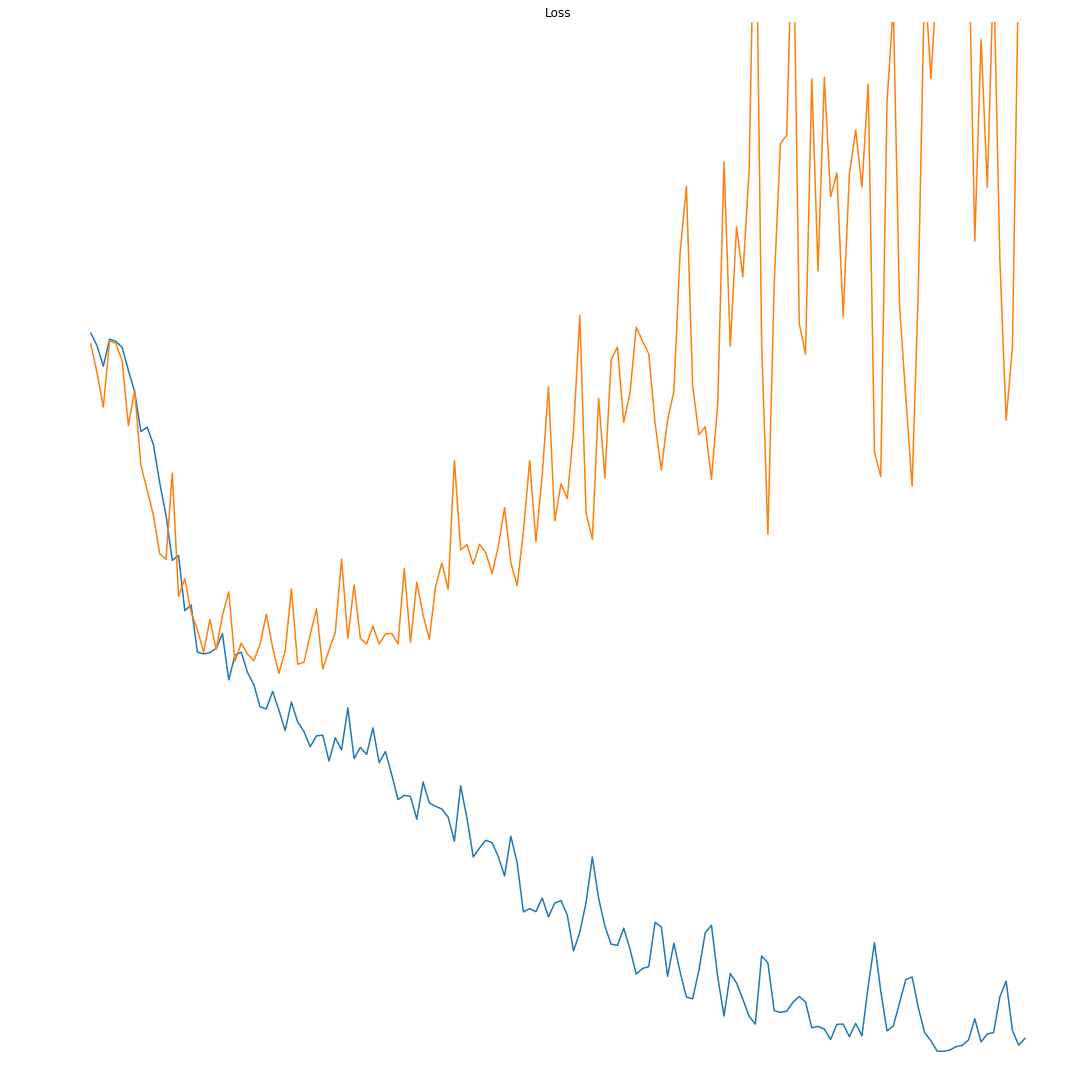

In [26]:
graphs = [res]

fig = plt.figure(figsize = (15, 15))
plt.axis('off')
plt.tight_layout()

for i, hist in enumerate(graphs):
    ax1 = fig.add_subplot(110 + i + 1)
    #plt.setp([ax1], xticks=[], yticks=[])
    ax1.set_ylim(0, 1.0)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title("Loss")
    ax1.set_ylabel('loss')
    #ax1.set_xlabel('epoch')
    ax1.plot(hist.history['loss'])
    ax1.plot(hist.history['val_loss'])
    ax1.xaxis.set_ticks(np.arange(0, epochs, epochs // 10))
    ax1.yaxis.set_ticks(np.arange(0, 1, 0.2))


In [27]:
test_file = 'data/test.json'
test_data = read_data(test_file)

In [28]:
#X_test, y_test, ids = prepare_dataset_ignore_angle(test_data, global_min, global_max)
X_test, y_test, ids = prepare_dataset_with_angles(test_data, ptocessing_lambda, ptocessing_angle_lambda)

In [29]:
from keras.models import load_model

prediction_model = load_model('saved_models/fold1.weights.best.from_scratch.hdf5')


In [30]:
prediction_model_0 = load_model('saved_models/fold0.weights.best.from_scratch.hdf5')
prediction_model_1 = load_model('saved_models/fold1.weights.best.from_scratch.hdf5')
prediction_model_2 = load_model('saved_models/fold2.weights.best.from_scratch.hdf5')
prediction_model_3 = load_model('saved_models/fold3.weights.best.from_scratch.hdf5')



In [31]:
X_train__, X_test__, y_train__, y_test__ = train_test_split(X_train_initial, y_train_initial, test_size=0.1, random_state=147)

res1 = prediction_model_0.predict(X_train__)
res2 = prediction_model_1.predict(X_train__)
res3 = prediction_model_2.predict(X_train__)
res4 = prediction_model_3.predict(X_train__)

res1v = prediction_model_0.predict(X_test__)
res2v = prediction_model_1.predict(X_test__)
res3v = prediction_model_2.predict(X_test__)
res4v = prediction_model_3.predict(X_test__)

In [32]:
print(res4v[0])

[  1.84739224e-06]


In [33]:
res_f = np.concatenate([res1, res2], axis = 1)
res_f_v = np.concatenate([res1v, res2v], axis = 1)\

res_f_mean = np.mean(res_f, axis=1)
res_f_v_mean = np.mean(res_f_v, axis=1)
print(res_f_mean.shape)

print(log_loss(y_train__, res_f_mean))
print(log_loss(y_test__, res_f_v_mean))

(1323,)
0.161517681746
0.210019761456


In [ ]:
d = np.sort(res_f_v, axis=1, kind='quicksort', order=None)
d1 = np.sort(res_f_v, axis=1, kind='quicksort', order=None)

rr = []
for item in d1:
    if np.mean(item) > 0.5:
        rr.append(np.max(item))
    else:
        rr.append(np.min(item))

print(y_test__.shape)
d = np.concatenate([d, np.expand_dims(y_test__, axis=1)], axis = 1)

#d = d[:,3:4]
print(log_loss(y_test__, rr))

for i in range(132):
    print(i, d[i])


In [ ]:
hh_channel, hv_channel = get_image_channels(X_test__, 6)
display_image(hh_channel)
display_image(hv_channel)


In [ ]:


lrc = AdaBoostClassifier(random_state = 3)
#lrc = SVC(random_state = 3)

results = {}
    
start = time() # Get start time
lrc.fit(res_f, y_train__)
end = time() # Get end time
results['train_time'] = end - start


start = time() # Get start time
predictions_test = lrc.predict(res_f_v)
predictions_train = lrc.predict(res_f)
end = time() # Get end time
    
results['pred_time'] = end - start
results['acc_train'] = accuracy_score(y_train__, predictions_train)
results['log_loss_train'] = log_loss(y_train__, predictions_train)
results['acc_test'] = accuracy_score(y_test__, predictions_test)
results['log_loss_test'] = log_loss(y_test__, predictions_test)
       
print ("{} trained on {} samples.".format(lrc.__class__.__name__, len(res_f)))

results


In [34]:
print(X_test.shape)

(8424, 75, 75, 3)


In [37]:
res1 = prediction_model_0.predict(X_test)
res2 = prediction_model_1.predict(X_test)
res_t = np.concatenate([res1, res2], axis = 1)
print(res_t.shape)
res = np.mean(res_t, axis=1)

(8424, 2)


In [38]:
print(res.shape)

(8424,)


In [39]:
print(y_test.shape)

(8424,)


In [40]:
print(y_test)

[0 0 0 ..., 0 0 0]


In [41]:
import csv
headers = ['id', 'is_iceberg']

with open('results.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile, quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(headers)

    for prediction, item_id in zip(res, ids):
        csv_writer.writerow([item_id, np.asscalar(prediction)])

    